<a href="https://colab.research.google.com/github/blakeobeans/kaggle_notebooks/blob/master/Ames%20Housing%20with%20Fast.ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predict the selling price.

### Import Data

In [0]:
#load relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
from fastai.tabular import * 
#show all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#display all rows
pd.options.display.max_rows = 4000

In [0]:
#import data from Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = '/content/drive/My Drive/Colab Notebooks/Kaggle/house-prices-advanced-regression-techniques'
os.chdir(path)
path

'/content/drive/My Drive/Colab Notebooks/Kaggle/house-prices-advanced-regression-techniques'

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Feature Engineering

In [0]:
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']
#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#### Missing Data

In [0]:
ntrain = train.shape[0]
ntest = test.shape[0]

# Creating y_train variable
y_train = train.SalePrice.values
# New all encompassing dataset
all_data = pd.concat((train, test), sort=True).reset_index(drop=True)
# Dropping the target
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [0]:
#caluclate % missing for each variable
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

Text(0.5, 0, 'Features')

Text(0, 0.5, 'Percent of missing values')

Text(0.5, 1.0, 'Percent missing data by feature')

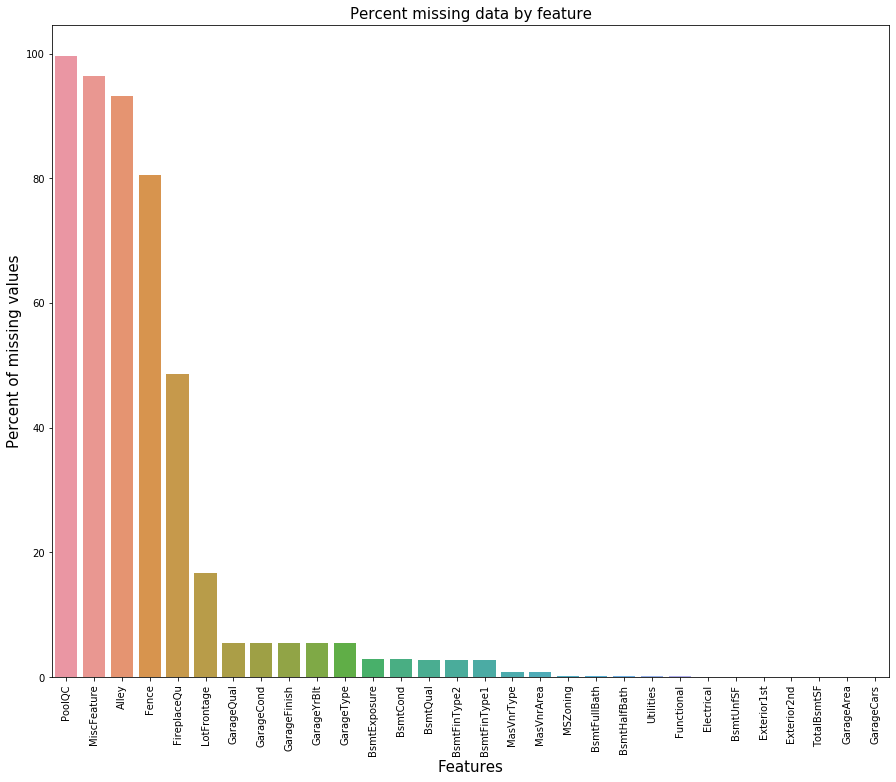

In [0]:
#visualize missing data
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

Most of the data are not missing. It's just that the "NA" value means that some feature is not present. For example, "NA" on PoolQC just means no pool is there.

In [0]:
#all features engineered below
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [0]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head() #just SalePrice from test data

,Missing Ratio


### Change Variable Types

In [0]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

### Back to original data

In [0]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [0]:
#add dependent variable back to training data set
y_train_temp = pd.DataFrame({'SalePrice': y_train[:,]})
train = pd.concat([train, y_train_temp], axis = 1)

### Outliers

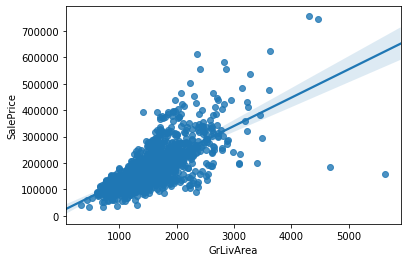

In [0]:
sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=True)
plt.show()

In [0]:
# Removing two very extreme outliers in the bottom right hand corner- choosing not to remove
# train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

### Transform Data

In [0]:
#Tranform data. procedures, see tabular.transform 
#FillMissing takes the median for continuous, and 0 flag for categorical although there are other options
#Categorify makes categorical variables categorical
#Normalize normalizes continuous variables 
procs = [FillMissing, Categorify, Normalize]

### Create DataBunch object

In [0]:
#instead of listing vars, faster to use select_dtypes() function from pandas
cat_names = train.select_dtypes(include=['object']).columns.tolist()
cont_names = train.select_dtypes(include=[np.number]).columns.tolist()
cont_names.remove('SalePrice') #remove continuous response variable

Before creating a DataBunch object, we'll create a TabularList. Thus, we can make modifications in the data block API.

In [0]:
#test databunch defined first
test = TabularList.from_df(df=test, 
                           cat_names=cat_names, 
                           cont_names=cont_names, 
                           procs=procs)

In [0]:
#see datablock core API for other methods
data = (TabularList.from_df(df=train, 
                            path='.', 
                            cat_names=cat_names, 
                            cont_names=cont_names, 
                            procs=procs)
                        .split_by_rand_pct(valid_pct = 0.2, #% in the validation set
                                           seed = 24) #create validation dataset
                        .label_from_df(cols = 'SalePrice', #still not sure what this does, but calling out the dependent variable
                                       label_cls = FloatList, #???
                                       log = True ) #take log of dependent variable
                        .add_test(test) #add the test set (see previous block)
                        .databunch()) #defaults from conversion to databunch, you can add batch size

In [0]:
#data.show_batch(rows = 10)

## Fit the Model

We'll let the embedding sizes be determined by default. The key metric is rmse of the log(SalePrice).

In [0]:
learn = tabular_learner(data, 
                        layers=[1000, 1000, 1000], #two cycles with 300 rows then 100 rows in the matrix 
                        #emb_szs = xxx, #embedding defaults usd
                        metrics=rmse, #metric of interest
                        ps = [.1, .1, .1], #sets the drop out between cycles
                        emb_drop = .1,  #embedding drop-out prior to training
                        #callback_fns = ShowGraph
                        )

In [0]:
#learn.model
#learn.summary()

First, we embed all of the categorical variables. There are 46 categorical variables.

BatchNorm1d is a complicated method of normalization. Linear is 238 in, 300 out. ReLU replaces the negatives with 0s. These three repeat, with one more linear of 100 x 1 for the prediction column.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02
Min loss divided by 10: 4.37E-02


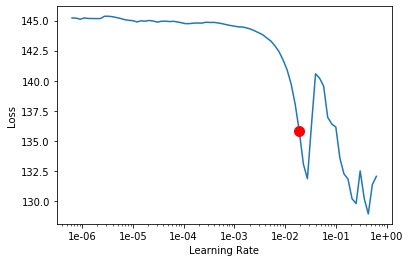

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(cyc_len = 50, 
                    max_lr=1e-1, 
                    wd=(1e-1), 
                    moms=(0.8, 0.7)
                   )

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.149623,0.116204,0.320019,00:01
1,0.144642,0.093049,0.293514,00:01
2,0.137648,0.066764,0.257394,00:01
3,0.137029,0.096836,0.296156,00:01
4,0.133591,0.100213,0.299060,00:01
5,0.137441,0.066807,0.257723,00:01
6,0.129623,0.065067,0.253345,00:02
7,0.128473,0.169584,0.411612,00:01
8,0.143968,0.228274,0.468543,00:01
9,0.312205,2.085831,1.444043,00:01


Trial Best: .009275; .093508

In [0]:
#learn.save('11.13.model')

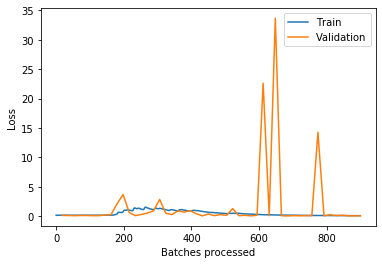

In [0]:
learn.recorder.plot_losses() #works best after running through a cycle (y limit decreases)

## Model Analysis

### Predictions

In [0]:
# get predictions
preds, targets = learn.get_preds(DatasetType.Test)
labels = [np.exp(p[0].data.item()) for p in preds]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [0]:
# create submission file to submit in Kaggle competition
submission = pd.DataFrame({'Id': test_ID, 'SalePrice': labels})
submission.head()

,Id,SalePrice
0,1461,inf
1,1462,inf
2,1463,inf
3,1464,inf
4,1465,inf


In [0]:
submission.to_csv('submission.csv', index=False)